## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('chronic_kidney_disease_full.csv')

### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer: Chronic kidney disease, after some outside research, seems to be driven by high blood pressure and diabetes. These are the features I'd like to focus on. Diabetes here is represented as 'dm', high blood pressure is defined as 'bp.'

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [3]:
df.isnull().sum().sum()

1012

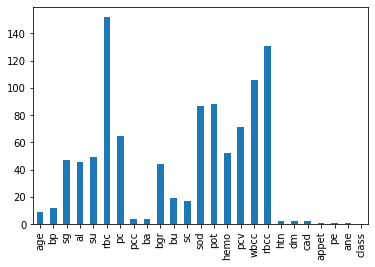

In [4]:
df.isnull().sum().plot(kind='bar')

There are ~1k missing values. A strong amount are coming from 'rbc', 'rbcc', and 'wbcc' columns which refer to red and white blood cell counts.

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

In [5]:
df.shape

(400, 25)

In [6]:
df.isnull().any(axis=1).sum()

242

242 rows with NaN values. We'd lose over half our data set is we dropped these rows. The downside here is that we drastically reduce the number of observations we have for training our data. In addition to this, there is potentially useful information in the non-NaN features of these rows that we'd be missing.

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer: The blood pressure readings could be innaccurate depending on how they are taken. Often times these values are taken through a manual check which introduces human error. Appetite is a value that appears to be very objective -- good/poor appetite, whether self reported or reecorded by a nurse, can introduce a LOT of gray area. Finally, for data that is handwritten, depending on data entry protocol it's highly possible that there are translation errors once the data has been put into a database.

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer:The model you can build here is one that predicts that everyone has CKD.

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: If having CKD is the positive classification (1), then the negative classification is not having CKD. We want to build a model that minimizes False Negatives. Specificity measures a models ability to predict a negative outcome. So we are optimizing toward this metric.

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer: This model will result in a significant amount of false positives. People would change their lives around a diagnosis that is untrue.

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer: Here, we want to minimize false positives. We can build a model that classifies everyone as not having CKD.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: We are minimizing false posities, and this is related to sensitivity.

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer: People with the disease would not be informed, which would risk their health/lives.

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [7]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [8]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [9]:
null_cols = list(df.isnull().any().index)

In [10]:
numerical_null_cols = list(df[null_cols].select_dtypes(exclude='object').columns)

In [11]:
for column in numerical_null_cols:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [12]:
df.isnull().sum()

age        0
bp         0
sg         0
al         0
su         0
rbc      152
pc        65
pcc        4
ba         4
bgr        0
bu         0
sc         0
sod        0
pot        0
hemo       0
pcv        0
wbcc       0
rbcc       0
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [13]:
from scipy import stats
nominal_null_list = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

for column in nominal_null_list:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [14]:
df.isnull().sum().sum()

0

In [15]:
df.head(3)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.02,1.0,0.0,normal,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.02,4.0,0.0,normal,normal,notpresent,notpresent,99.0,...,38.0,6000.0,5.2,no,no,no,good,no,no,ckd
2,62.0,80.0,1.01,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,5.2,no,yes,no,poor,no,yes,ckd


In [16]:
df['class'].unique()

array(['ckd', 'notckd'], dtype=object)

In [17]:
df['class'] = df['class'].map({'ckd':1, 'notckd':0})

In [18]:
dummylist = list(df.select_dtypes('object').columns)

In [19]:
dummy_df = pd.get_dummies(df[dummylist], drop_first=True)

In [20]:
df_combined = pd.concat([df,dummy_df], axis=1)

In [21]:
df_combined.shape, df.shape, dummy_df.shape

((400, 35), (400, 25), (400, 10))

In [22]:
dummylist

['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

In [23]:
df_combined = df_combined.drop(columns=dummylist)

In [24]:
y =df_combined['class']
X = df_combined.drop(columns=['class'])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [26]:
logreg = LogisticRegressionCV(Cs=100, penalty='l1', solver='liblinear', cv=5)

In [27]:
X_train.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,rbc_normal,pc_normal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes
157,62.0,70.0,1.025,3.0,0.0,122.0,42.0,1.7,136.0,4.7,...,1,0,0,0,1,1,0,0,0,0
109,54.0,70.0,1.020,0.0,0.0,233.0,50.1,1.9,135.0,3.5,...,1,1,0,0,0,1,0,0,0,0
17,47.0,80.0,1.020,0.0,0.0,114.0,87.0,5.2,139.0,3.7,...,1,1,0,0,1,0,0,1,0,0
347,43.0,60.0,1.025,0.0,0.0,108.0,25.0,1.0,144.0,5.0,...,1,1,0,0,0,0,0,0,0,0
24,42.0,100.0,1.015,4.0,0.0,99.0,50.0,1.4,129.0,4.0,...,1,0,0,1,1,0,0,1,0,0


In [28]:
cross_val_score(logreg, X_train, y_train, cv=4).mean()

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

0.9681057358644621

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [29]:
logreg.fit(X_train,y_train)
logreg.score(X_train,y_train)
logreg.score(X_test,y_test)

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

0.9833333333333333

In [30]:
np.exp(logreg.coef_)[0,0]

0.9942040517131803

In [31]:
len(X_train.columns), len(logreg.coef_[0])

(24, 24)

In [32]:
X_train.columns[0]

'age'

"Age is not a strong predictor of chronic kidney disease"

Having diabetes increases the odds of having chronic kidney diseas by 170 times

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

In [33]:
X_train.columns[19]

'dm_yes'

In [34]:
np.exp(logreg.coef_[0,19])

225.1835617970376

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer: It's a relatively simple model to implement and the coefficients are human interpretable once transformed.

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

It makes sense to do it on our test data because we've already fit the model to our training data.

In [35]:
from sklearn.metrics import confusion_matrix
logreg.fit(X_train,y_train)
lrpreds = logreg.predict(X_test)

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

In [36]:
tn, fp, fn, tp = confusion_matrix(y_test,lrpreds).ravel()

In [37]:
spec = tn / (tn + fp)

print(f'Specificity: {spec}')

Specificity: 1.0


In [38]:
sens = tp / (tp + fp)

print(f'Sensitivity: {sens}')

Sensitivity: 1.0


In [39]:
fn

2

In [40]:
# Let's create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in logreg.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

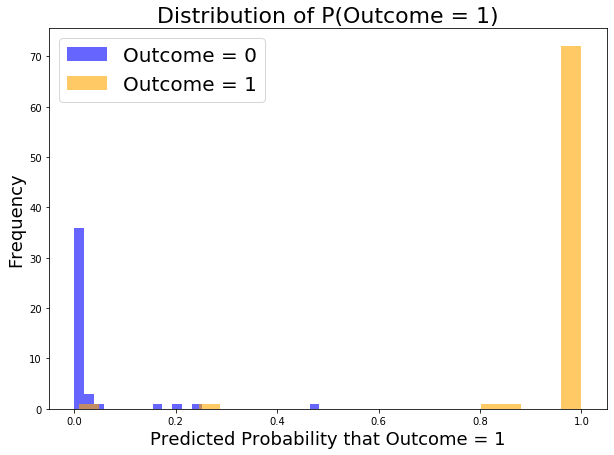

In [41]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer: With our model I think we should not be overly concerned with false positives. The worst case scenario here is false negatives, as someone can go on with their lives not thinking they are sick. For that reason, sensitivity is important.

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

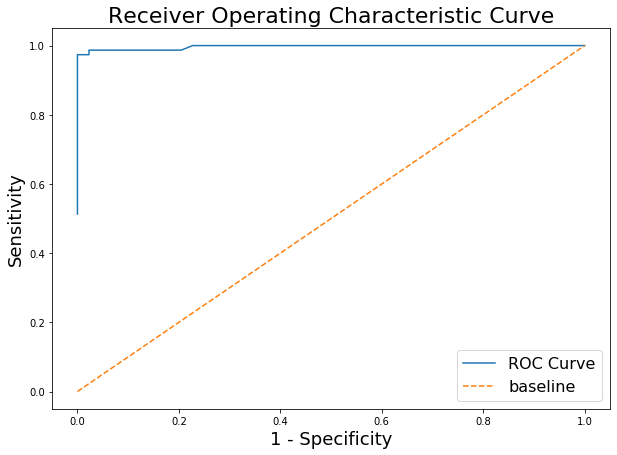

In [42]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

In [43]:
df['class'].value_counts()

1    250
0    150
Name: class, dtype: int64

Answer: It's a problem because it can result in high variance. If we have a model that has a very small number of positive observations, and in reality there is a very high number for a given situation, we will not be able to accurately make predictions. In this case, there is some imbalance that should be addressed.

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer: We need to train our model on data that has both sick and healthy people. If we train it predominately on one or the other our model won't be effective in determining ckd v non ckd.

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [50]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=20000,
    n_features=24,
    n_informative=15,
    random_state=123
)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

sc = StandardScaler()
X_train_sc_ov = sc.fit_transform(X_train)
X_test_sc_ov = sc.transform(X_test)

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [51]:
# Fit unregularizted logistic regression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_sc_ov,y_train)
# Overfit!
print(logreg.score(X_train_sc_ov,y_train))
print(logreg.score(X_test_sc_ov,y_test))

0.7981333333333334
0.8


C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!

In [44]:
X_train.columns[1],  X_train.columns[19]

('bp', 'dm_yes')

In [45]:
np.exp(logreg.coef_[0,19])

187.0960050192136

In [46]:
np.exp(logreg.coef_[0,1])

1.143970065910063

High blood pressure increases your chance of CKD by 1.14x; diabetes increases the odds of getting CKD by ~187x.